In [1]:
import scanpy as sc
import surgeon

Using TensorFlow backend.


In [2]:
sc.settings.set_figure_params(dpi=200)

In [3]:
condition_key = "study"
cell_type_key = 'cell_type'
target_conditions = ["Pancreas Celseq", "Pancreas CelSeq2"]

# Loading four Toy datasets and data preparation

In [4]:
adata = sc.read("./data/pancreas/pancreas_count.h5ad")
adata

AnnData object with n_obs × n_vars = 15921 × 15369 
    obs: 'batch', 'study', 'cell_type'

## Number of cells in each batch

In [5]:
adata.obs[condition_key].value_counts()

Pancreas inDrop         8569
Pancreas SS2            2989
Pancreas CelSeq2        2449
Pancreas Celseq         1276
Pancreas Fluidigm C1     638
Name: study, dtype: int64

## Now we leave out one study (SS2) for training the newtork

In [6]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 12196 × 15369 
    obs: 'batch', 'study', 'cell_type'

In [7]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 3725 × 15369 
    obs: 'batch', 'study', 'cell_type'

In [8]:
adata_for_training = surgeon.utils.normalize(adata_for_training, 
                                             filter_min_counts=False, 
                                             normalize_input=False, 
                                             size_factors=True,
                                             logtrans_input=True,
                                             n_top_genes=2000,
                                            )

Trying to set attribute `.obs` of view, making a copy.


In [9]:
adata_out_of_sample = surgeon.utils.normalize(adata_out_of_sample, 
                                              filter_min_counts=False, 
                                              normalize_input=False, 
                                              size_factors=True,
                                              logtrans_input=True,
                                              n_top_genes=2000,
                                             )

Trying to set attribute `.obs` of view, making a copy.


## Train/Test Split

In [10]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.85)

In [11]:
train_adata.shape, valid_adata.shape

((10366, 2000), (1830, 2000))

In [12]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [13]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=20,
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.001,
                             eta=1.0,
                             scale_factor=1.0,
                             clip_value=5.0,
                             loss_fn='nb',
                             model_path="./models/CVAE/convergence/Pancreas_count/",
                             dropout_rate=0.2,
                             )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/mohsen/scnet/surgeon/models/_cvae.py:149: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 3)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2003)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          1025536     concatenate_1[0][0]              
__________

## We assign each study to a numerical label 

In [14]:
conditions = adata_for_training.obs[condition_key].unique().tolist()
condition_encoder = surgeon.utils.create_dictionary(conditions, target_conditions)
condition_encoder

{'Pancreas inDrop': 0, 'Pancreas Fluidigm C1': 1, 'Pancreas SS2': 2}

## Training the network

In [15]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=1000,
              batch_size=32, 
              early_stop_limit=15,
              lr_reducer=10, 
              n_per_epoch=0,
              save=True, 
              verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 10366 samples, validate on 1830 samples
Epoch 1/1000
 - 4s - loss: 0.7172 - nb: 0.7172 - val_loss: 0.6680 - val_nb: 0.6680
Epoch 2/1000
 - 2s - loss: 0.6640 - nb: 0.6640 - val_loss: 0.6575 - val_nb: 0.6575
Epoch 3/1000
 - 2s - loss: 0.6556 - nb: 0.6556 - val_loss: 0.6511 - val_nb: 0.6511
Epoch 4/1000
 - 2s - loss: 0.6510 - nb: 0.6510 - val_loss: 0.6480 - val_nb: 0.6480
Epoch 5/1000
 - 2s - loss: 0.6475 - nb: 0.6475 - val_loss: 0.6472 - val_nb: 0.6472
Epoch 6/1000
 - 2s - loss: 0.6448 - nb: 0.6448 - val_loss: 0.6460 - val_nb: 0.6460
Epoch 7/1000
 - 2s - loss: 0.6429 - nb: 0.6429 - val_loss: 0.6441 - val_nb: 0.6441
Epoch 8/1000
 - 2s - loss: 0.6413 - nb: 0.6413 - val_loss: 0.6430 - val_nb: 0.6430
Epoch 9/1000
 - 2s - loss: 0.6402 - nb: 0.6402 - val_loss: 0.6422 - val_nb: 0.6422
Epoch 10/1000
 - 2s - loss: 0.6390 - nb: 0.6390 - val_loss: 0.6423 - val_nb: 0.6423
Epoch 11/1000
 - 2s - loss: 0.6378 - nb: 0.6378 - val_loss: 0.6406 - val

In [16]:
network.condition_encoder

{'Pancreas inDrop': 0, 'Pancreas Fluidigm C1': 1, 'Pancreas SS2': 2}

In [17]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [18]:
latent_adata = network.to_latent(train_adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 10366 × 20 
    obs: 'batch', 'study', 'cell_type', 'n_counts', 'size_factors'

In [19]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

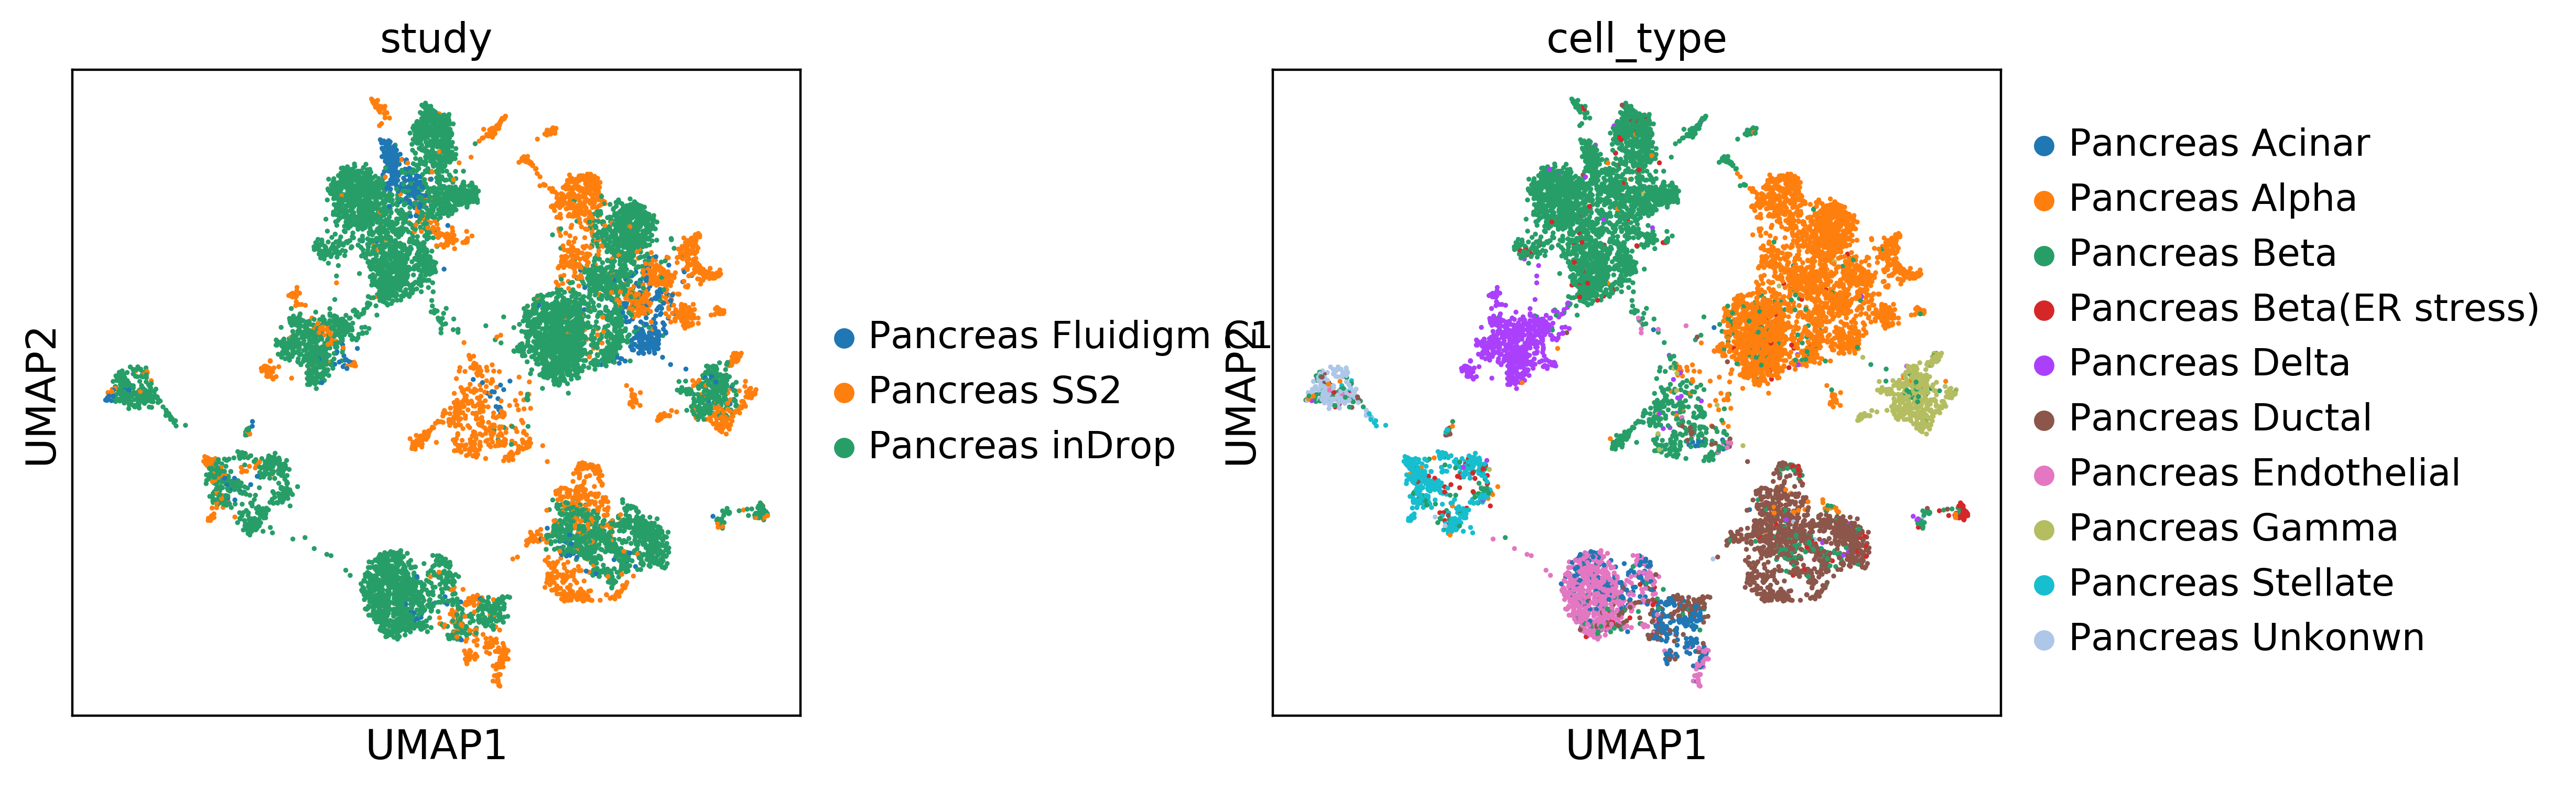

In [20]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

# Perfroming architecture Surgery

In [21]:
new_network = surgeon.operate(network, 
                              new_conditions=target_conditions,
                              init='Xavier', 
                              freeze=True)

/home/mohsen/scnet/surgeon/models/_cvae.py:149: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 5)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 2005)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          1026560     concatenate_3[0][0]              
__________

In [22]:
new_network.condition_encoder

{'Pancreas inDrop': 0,
 'Pancreas Fluidigm C1': 1,
 'Pancreas SS2': 2,
 'Pancreas Celseq': 3,
 'Pancreas CelSeq2': 4}

## Train with small new dataset containing out-of-sample condition

In [23]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.85)

In [24]:
train_adata.shape, valid_adata.shape

((3166, 2000), (559, 2000))

In [25]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=300,
                  batch_size=32, 
                  early_stop_limit=20,
                  lr_reducer=15, 
                  n_per_epoch=5,
                  score_filename="./results/convergence/pancreas/scores_scNetFreezed_count.log",
                  save=True, 
                  verbose=2)

Train on 3166 samples, validate on 559 samples
Epoch 1/300
 - 2s - loss: 1.3575 - nb: 1.3575 - val_loss: 1.0978 - val_nb: 1.0978
Epoch 0: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.1337 - ARI: 0.2442 - NMI: 0.2317 - EBM: 0.6363
Epoch 2/300
 - 1s - loss: 1.1932 - nb: 1.1932 - val_loss: 1.0416 - val_nb: 1.0416
Epoch 3/300
 - 1s - loss: 1.1341 - nb: 1.1341 - val_loss: 1.0120 - val_nb: 1.0120
Epoch 4/300
 - 1s - loss: 1.1025 - nb: 1.1025 - val_loss: 1.0068 - val_nb: 1.0068
Epoch 5/300
 - 0s - loss: 1.0803 - nb: 1.0803 - val_loss: 1.0129 - val_nb: 1.0129
Epoch 6/300
 - 0s - loss: 1.0667 - nb: 1.0667 - val_loss: 0.9893 - val_nb: 0.9893
Epoch 5: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.1653 - ARI: 0.2268 - NMI: 0.1707 - EBM: 0.6363
Epoch 7/300
 - 0s - loss: 1.0484 - nb: 1.0484 - val_loss: 1.0390 - val_nb: 1.0390
Epoch 8/300
 - 0s - loss: 1.0418 - nb: 1.0418 - val_loss: 1.0108 - val_nb: 1.0108
Epoch 9/300
 - 0s - loss: 1.0330 - nb: 1.0330 - val_loss: 1.0045 - val_nb: 1.0045
Epoch 10/300
 - 0s - loss: 1.0256 - nb: 1.0256 - val_loss: 0.9938 - val_nb: 0.9938
Epoch 11/300
 - 0s - loss: 1.0202 - nb: 1.0202 - val_loss: 1.0166 - val_nb: 1.0166
Epoch 10: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.1697 - ARI: 0.2039 - NMI: 0.1521 - EBM: 0.6346
Epoch 12/300
 - 1s - loss: 1.0158 - nb: 1.0158 - val_loss: 1.0198 - val_nb: 1.0198
Epoch 13/300
 - 1s - loss: 1.0193 - nb: 1.0193 - val_loss: 0.9872 - val_nb: 0.9872
Epoch 14/300
 - 1s - loss: 1.0079 - nb: 1.0079 - val_loss: 1.0064 - val_nb: 1.0064
Epoch 15/300
 - 1s - loss: 1.0050 - nb: 1.0050 - val_loss: 0.9921 - val_nb: 0.9921
Epoch 16/300
 - 1s - loss: 1.0028 - nb: 1.0028 - val_loss: 0.9961 - val_nb: 0.9961
Epoch 15: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.1645 - ARI: 0.2019 - NMI: 0.1345 - EBM: 0.6317
Epoch 17/300
 - 1s - loss: 0.9992 - nb: 0.9992 - val_loss: 0.9823 - val_nb: 0.9823
Epoch 18/300
 - 1s - loss: 0.9937 - nb: 0.9937 - val_loss: 0.9669 - val_nb: 0.9669
Epoch 19/300
 - 1s - loss: 0.9939 - nb: 0.9939 - val_loss: 0.9714 - val_nb: 0.9714
Epoch 20/300
 - 1s - loss: 0.9972 - nb: 0.9972 - val_loss: 0.9650 - val_nb: 0.9650
Epoch 21/300
 - 1s - loss: 0.9874 - nb: 0.9874 - val_loss: 0.9838 - val_nb: 0.9838
Epoch 20: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.1564 - ARI: 0.2001 - NMI: 0.1295 - EBM: 0.6336
Epoch 22/300
 - 1s - loss: 0.9847 - nb: 0.9847 - val_loss: 0.9751 - val_nb: 0.9751
Epoch 23/300
 - 1s - loss: 0.9878 - nb: 0.9878 - val_loss: 0.9772 - val_nb: 0.9772
Epoch 24/300
 - 0s - loss: 0.9860 - nb: 0.9860 - val_loss: 0.9789 - val_nb: 0.9789
Epoch 25/300
 - 0s - loss: 0.9904 - nb: 0.9904 - val_loss: 0.9726 - val_nb: 0.9726
Epoch 26/300
 - 0s - loss: 0.9853 - nb: 0.9853 - val_loss: 0.9540 - val_nb: 0.9540
Epoch 25: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.1579 - ARI: 0.1608 - NMI: 0.1395 - EBM: 0.6388
Epoch 27/300
 - 1s - loss: 0.9788 - nb: 0.9788 - val_loss: 0.9812 - val_nb: 0.9812
Epoch 28/300
 - 1s - loss: 0.9829 - nb: 0.9829 - val_loss: 0.9596 - val_nb: 0.9596
Epoch 29/300
 - 1s - loss: 0.9857 - nb: 0.9857 - val_loss: 0.9778 - val_nb: 0.9778
Epoch 30/300
 - 1s - loss: 0.9764 - nb: 0.9764 - val_loss: 0.9766 - val_nb: 0.9766
Epoch 31/300
 - 1s - loss: 0.9821 - nb: 0.9821 - val_loss: 0.9747 - val_nb: 0.9747
Epoch 30: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.1541 - ARI: 0.1964 - NMI: 0.1256 - EBM: 0.6351
Epoch 32/300
 - 1s - loss: 0.9769 - nb: 0.9769 - val_loss: 0.9609 - val_nb: 0.9609
Epoch 33/300
 - 1s - loss: 0.9768 - nb: 0.9768 - val_loss: 0.9860 - val_nb: 0.9860
Epoch 34/300
 - 1s - loss: 0.9767 - nb: 0.9767 - val_loss: 0.9565 - val_nb: 0.9565
Epoch 35/300
 - 1s - loss: 0.9705 - nb: 0.9705 - val_loss: 0.9671 - val_nb: 0.9671
Epoch 36/300
 - 1s - loss: 0.9737 - nb: 0.9737 - val_loss: 0.9638 - val_nb: 0.9638
Epoch 35: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.1486 - ARI: 0.1910 - NMI: 0.1200 - EBM: 0.6362
Epoch 37/300
 - 1s - loss: 0.9733 - nb: 0.9733 - val_loss: 0.9474 - val_nb: 0.9474
Epoch 38/300
 - 1s - loss: 0.9743 - nb: 0.9743 - val_loss: 0.9684 - val_nb: 0.9684
Epoch 39/300
 - 1s - loss: 0.9757 - nb: 0.9757 - val_loss: 0.9593 - val_nb: 0.9593
Epoch 40/300
 - 1s - loss: 0.9722 - nb: 0.9722 - val_loss: 0.9552 - val_nb: 0.9552
Epoch 41/300
 - 1s - loss: 0.9744 - nb: 0.9744 - val_loss: 0.9670 - val_nb: 0.9670
Epoch 40: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.1477 - ARI: 0.1674 - NMI: 0.1370 - EBM: 0.6323
Epoch 42/300
 - 1s - loss: 0.9718 - nb: 0.9718 - val_loss: 0.9498 - val_nb: 0.9498
Epoch 43/300
 - 1s - loss: 0.9704 - nb: 0.9704 - val_loss: 0.9634 - val_nb: 0.9634
Epoch 44/300
 - 1s - loss: 0.9679 - nb: 0.9679 - val_loss: 0.9695 - val_nb: 0.9695
Epoch 45/300
 - 1s - loss: 0.9761 - nb: 0.9761 - val_loss: 0.9558 - val_nb: 0.9558
Epoch 46/300
 - 1s - loss: 0.9671 - nb: 0.9671 - val_loss: 0.9601 - val_nb: 0.9601
Epoch 45: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.1491 - ARI: 0.1634 - NMI: 0.1328 - EBM: 0.6290
Epoch 47/300
 - 1s - loss: 0.9714 - nb: 0.9714 - val_loss: 0.9577 - val_nb: 0.9577
Epoch 48/300
 - 1s - loss: 0.9748 - nb: 0.9748 - val_loss: 0.9572 - val_nb: 0.9572
Epoch 49/300
 - 1s - loss: 0.9715 - nb: 0.9715 - val_loss: 0.9633 - val_nb: 0.9633
Epoch 50/300
 - 1s - loss: 0.9672 - nb: 0.9672 - val_loss: 0.9633 - val_nb: 0.9633
Epoch 51/300
 - 1s - loss: 0.9691 - nb: 0.9691 - val_loss: 0.9573 - val_nb: 0.9573
Epoch 50: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.1431 - ARI: 0.1894 - NMI: 0.1177 - EBM: 0.6322
Epoch 52/300
 - 1s - loss: 0.9698 - nb: 0.9698 - val_loss: 0.9796 - val_nb: 0.9796
Epoch 53/300
 - 0s - loss: 0.9678 - nb: 0.9678 - val_loss: 0.9589 - val_nb: 0.9589
Epoch 54/300
 - 0s - loss: 0.9654 - nb: 0.9654 - val_loss: 0.9595 - val_nb: 0.9595
Epoch 55/300
 - 0s - loss: 0.9677 - nb: 0.9677 - val_loss: 0.9581 - val_nb: 0.9581
Epoch 56/300
 - 0s - loss: 0.9645 - nb: 0.9645 - val_loss: 0.9593 - val_nb: 0.9593
Epoch 55: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.1436 - ARI: 0.1607 - NMI: 0.1286 - EBM: 0.6316
Epoch 57/300
 - 1s - loss: 0.9694 - nb: 0.9694 - val_loss: 0.9573 - val_nb: 0.9573


In [26]:
encoder_labels, _ = surgeon.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [27]:
adata_out_of_sample.obs[condition_key].value_counts()

Pancreas CelSeq2    2449
Pancreas Celseq     1276
Name: study, dtype: int64

In [28]:
latent_adata = new_network.to_latent(adata_out_of_sample, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 3725 × 20 
    obs: 'batch', 'study', 'cell_type', 'n_counts', 'size_factors'

In [29]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

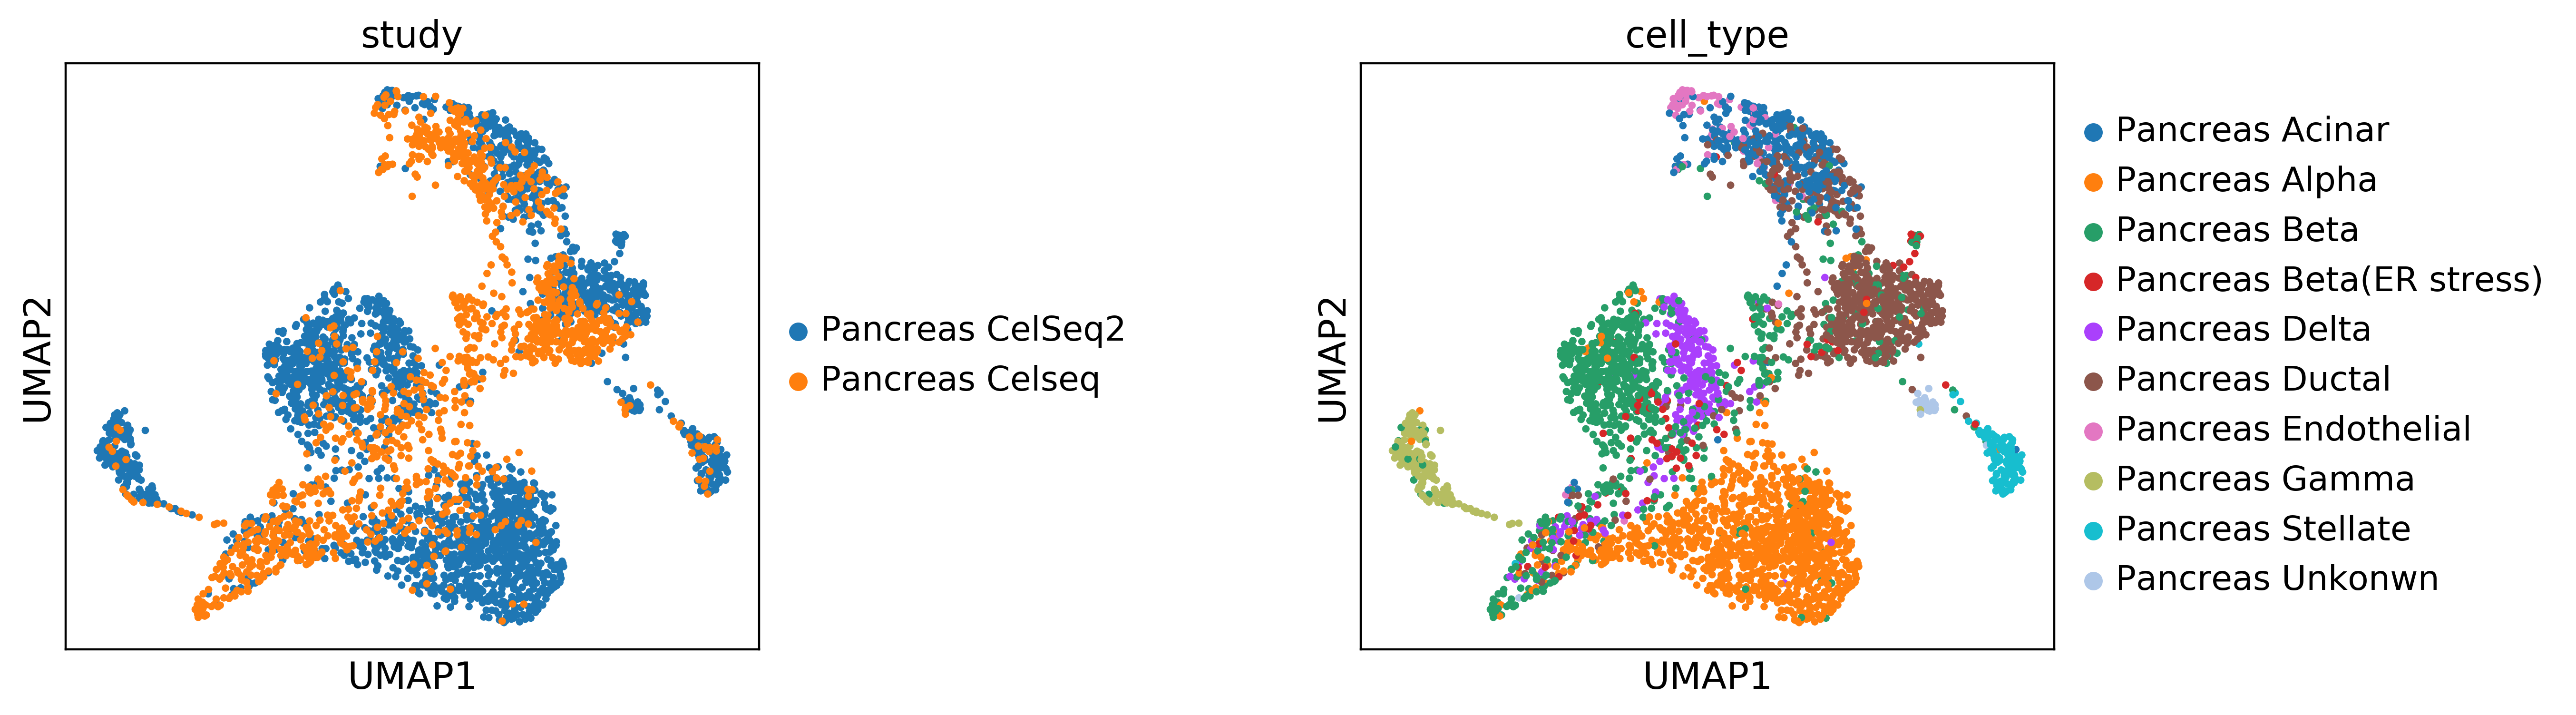

In [30]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.7)